In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Inputs

In [2]:
 
tags = []
tags = [
#         'QCD_HT_all, background',
#         'WLNu, background',
#         'ZNunu_HT_all, background',
#         'TT_Lep, background',
#         'All, background',
#         'QCD_HT50to100, background',
        'H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/'

# file names

fnames = {}

fnames['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh175_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh150_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh127_pl1000_ev100000_1pb_weighted.root'
# fnames['QCD_HT50to100, background'] = 'normalized/QCD_HT50to100_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_v6-v1_v2_v1_1pb_weighted.root'
# fnames['QCD_HT_all, background'] = 'skimmed/skim_qcd_ht_all.root'
fnames['QCD_HT_all, background'] = 'normalized/QCD_HTbinned_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu, background'] = 'normalized/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'normalized/ZJetsToNuNu_HTbinned__13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'normalized/TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['All, background'] = 'normalized/Bkg_1pb_weighted.root'
# fnames['QCD_HT_all, background'] = 'skimmed/SSSSSS.root'


# output plots directory
# out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/'
out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200121/'


# colors
cols = {}

# cols['QCD_HT50to100, background'] = 215
cols['QCD_HT_all, background'] = 215
cols['WLNu, background'] = 227
cols['ZNunu_HT_all, background'] = 221
cols['TT_Lep, background'] = 209
cols['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] = 207
cols['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'] = 205
cols['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'] = 94
cols['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] = 79
cols['All, background'] = 1
#cols['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 221
#cols['W(lv)Jets, background'] = 209


#styles
stys = {}

# stys['QCD_HT50to100, background'] = 3
stys['QCD_HT_all, background'] = 3
stys['WLNu, background'] = 4
stys['ZNunu_HT_all, background'] = 2
stys['TT_Lep, background'] = 7
stys['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] = 5
stys['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'] = 6
stys['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'] = 8
stys['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] = 9
stys['All, background'] = 1
#stys['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 2
#stys['W(lv)Jets, background'] = 1


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    if 'back' not in tag:
        calo_jet_amax = v['gLLP0_EB'].array()
        print(calo_jet_amax[:10])



/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/SusyLLP_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fbbd1845860> OrderedDict([('H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fbbd1845860>)])
[[0.009129958 0.0 0.0 0.6193744] [0.0119053675 0.0 0.0 0.20475802 0.37917507] [] ... [0.0] [0.37371102 0.030051181 0.21926512 0.08870697] [0.46424305 0.0]]
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
[ True  True  True False False  True  True False  True  True]
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/SusyLLP_n3n2-n1-hbb-hbb_mh175_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fbbcb943e80> OrderedDict([('H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree'

## variables

In [3]:
# pf jet

trg_path = 310
# 310 HLT_PFMET120_PFMHT120_IDTight

met_cut = 50

met_den_all = {}
met_den_1 = {}
met_den_2 = {}
met_num_all = {}
met_num_1 = {}
met_num_2 = {}

for k,v in tree.items(): 
    print(k,v)
    
    met_den_all[k] = {}
    met_den_1[k] = {}
    met_den_1[k] = {}
    met_num_all[k] = {}
    met_num_1[k] = {}
    met_num_2[k] = {}
 
    #branches

    hlt = v['HLTDecision'].array()
    met = v['met'].array()
    
    acc0_eb = v['gLLP0_EB'].array()
    acc1_eb = v['gLLP1_EB'].array() 
    
    #acceptance requirement
    acc_eb_all_str = np.logical_or(acc0_eb==1, acc1_eb==1)
    
    acc_eb_llp0_str = np.logical_and(acc0_eb==1, acc1_eb==0)
    acc_eb_llp1_str = np.logical_and(acc0_eb==0, acc1_eb==1)
    acc_eb_1_str = np.logical_or(acc_eb_llp0_str,acc_eb_llp1_str)
    
    acc_eb_2_str = np.logical_and(acc0_eb==1, acc1_eb==1)
    
    if 'background' in k:
        acc_eb_all_str = 1
        acc_eb_1_str = 1
        acc_eb_2_str = 1
        
    acc_eb_all_str = np.logical_and(acc_eb_all_str, met>met_cut)
    acc_eb_1_str = np.logical_and(acc_eb_1_str, met>met_cut)
    acc_eb_2_str = np.logical_and(acc_eb_2_str, met>met_cut)

    # select only triggered events
#     print('trigger decision',hlt[:,310])
#     print('trigger shape',np.zeros(hlt[:,0].shape))
#     sel_hlt_triggered = np.zeros(hlt[:,0].shape)
    sel_hlt_triggered = 1
    sel_hlt_den  = np.logical_or(sel_hlt_triggered, hlt[:,trg_path])
    sel_hlt_num  = np.logical_and(sel_hlt_triggered, hlt[:,trg_path])
    
    # denominator string
    den_all_str = np.logical_and(acc_eb_all_str, sel_hlt_den)
    den_1_str = np.logical_and(acc_eb_1_str, sel_hlt_den)
    den_2_str = np.logical_and(acc_eb_2_str, sel_hlt_den)
    
    #numerator string
    num_all_str = np.logical_and(acc_eb_all_str, sel_hlt_num)
    num_1_str = np.logical_and(acc_eb_1_str, sel_hlt_num)
    num_2_str = np.logical_and(acc_eb_2_str, sel_hlt_num)
    
    # variables    
    den_all = met[den_all_str]
    den_1 = met[den_1_str]
    den_2 = met[den_2_str]
    
    num_all = met[num_all_str]
    num_1 = met[num_1_str]
    num_2 = met[num_2_str]
    
    #assign
    met_den_all[k] = den_all
    met_den_1[k] = den_1
    met_den_2[k] = den_2

    met_num_all[k] = num_all
    met_num_1[k] = num_1
    met_num_2[k] = num_2


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>


## met distributions

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
[ 69.918335 113.90167   80.70827   53.051704  71.79652  280.2716
  78.62684   60.42342  120.88208   52.163403]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
[226.87988 160.72716 162.24513 315.9664  301.0925  179.32684 357.03992
 167.6832  163.47295 175.39574]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
[253.62779 247.74889 388.46805 164.00304 220.11597 182.4582  179.52338
 388.23236 230.23045 172.26866]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>
[154.59485 187.04994 169.16882 321.285   474.34793 334.21796 221.09474
 262.20224 235.92462 247.85791]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


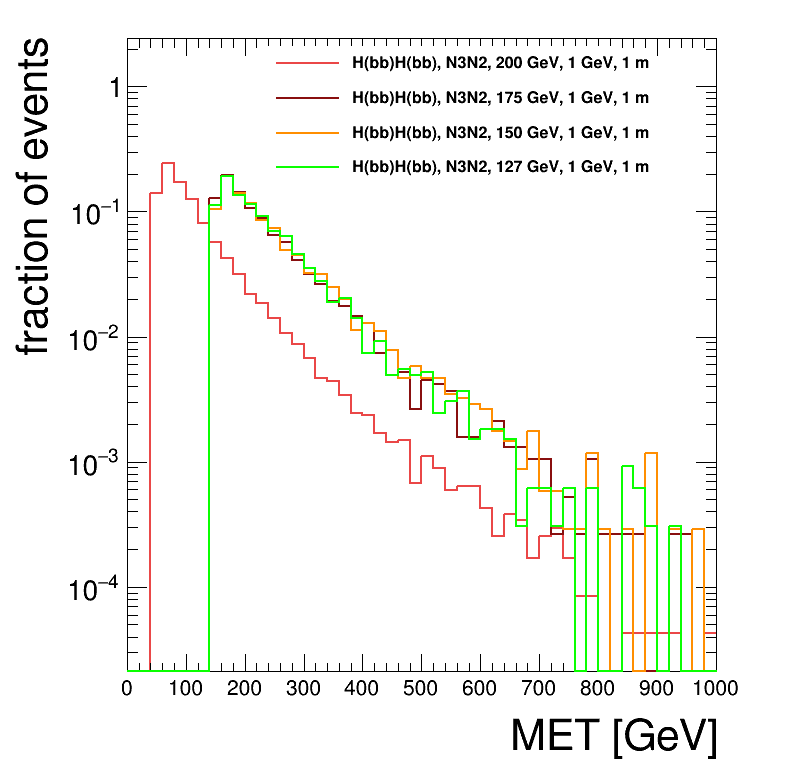

In [5]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = met_den_all[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_den_all.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
[113.90167   80.70827   53.051704  71.79652  280.2716   120.88208
  52.163403  76.44671   65.178925  83.03823 ]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
[226.87988 160.72716 162.24513 315.9664  301.0925  179.32684 167.6832
 163.47295 269.6916  255.02637]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
[253.62779 247.74889 388.46805 164.00304 220.11597 182.4582  179.52338
 388.23236 230.23045 172.26866]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>
[154.59485 187.04994 169.16882 321.285   474.34793 334.21796 221.09474
 262.20224 235.92462 247.85791]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


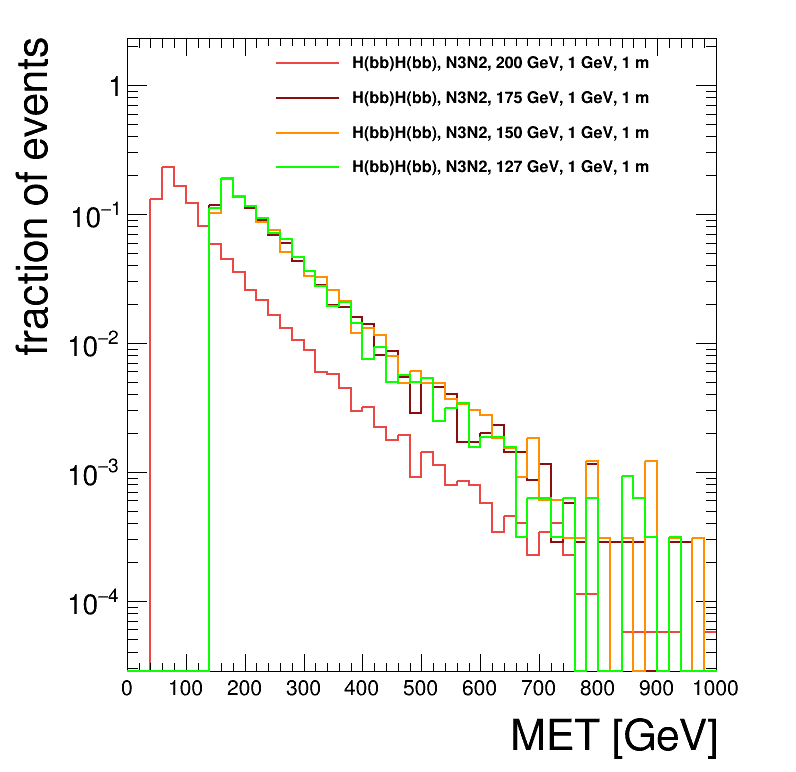

In [6]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = met_den_1[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_den_1.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
[ 69.918335  78.62684   60.42342   87.10831  138.40735   72.22785
  86.22536   62.424     85.67321   79.277115]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
[357.03992 175.39574 192.82822 166.07506 263.81476 191.32048 225.11838
 193.22992 158.25238 267.20688]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
[271.55627 172.10735 212.86575 189.91356 162.74739 168.1627  150.08948
 162.9984  227.48718 450.797  ]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>
[165.92542 197.84497 245.0651  570.55347 159.27563 207.31319 172.12306
 168.1785  206.02278 172.45016]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


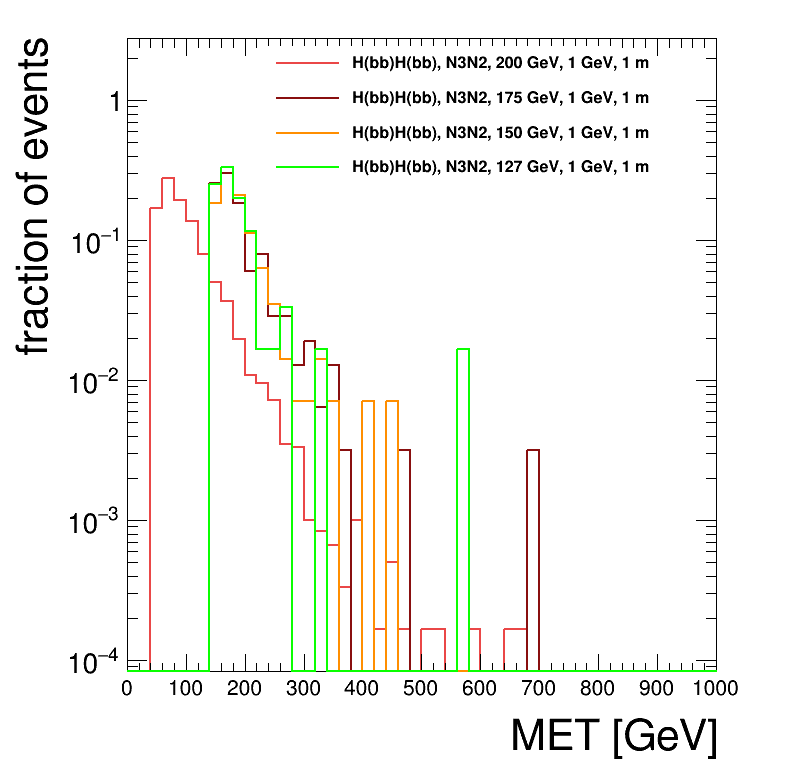

In [7]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = met_den_2[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_den_2.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
[280.2716   293.827    156.49886  105.72377  164.48952  188.70253
 143.84653  242.15868   79.277115 192.62206 ]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
[226.87988 315.9664  301.0925  357.03992 175.39574 255.02637 198.6806
 177.7487  178.34004 219.03648]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
[388.46805 220.11597 182.4582  179.52338 230.23045 172.26866 233.28674
 181.1584  204.74777 208.67937]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>
[154.59485 321.285   474.34793 334.21796 262.20224 235.92462 195.2827
 159.15292 244.48717 225.14922]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


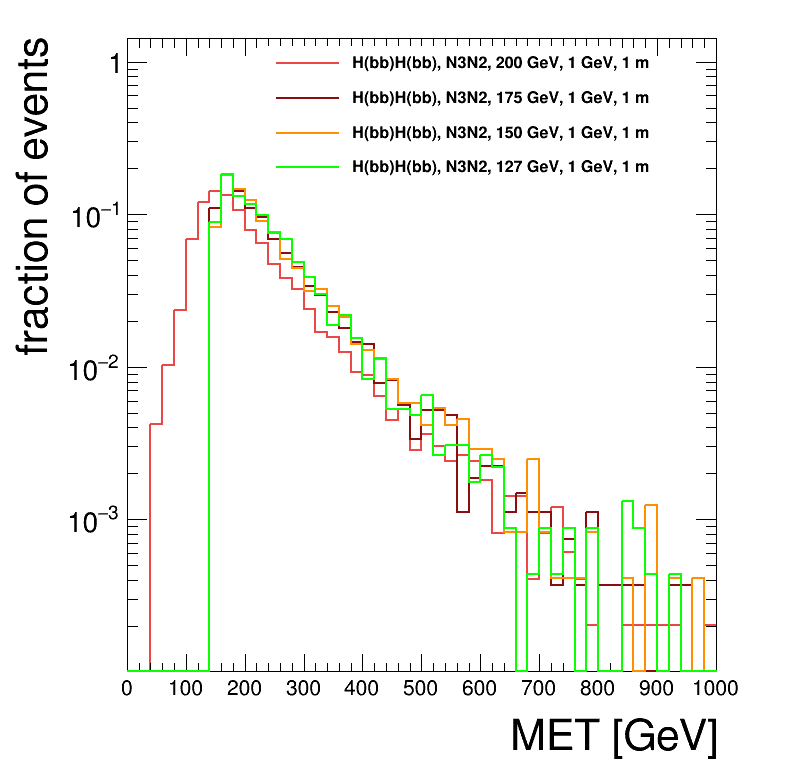

In [8]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)


    j_gamma_all = met_num_all[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_num_all.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
[280.2716  293.827   156.49886 105.72377 164.48952 188.70253 143.84653
 242.15868 192.62206 296.15747]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
[226.87988 315.9664  301.0925  255.02637 198.6806  177.7487  178.34004
 219.03648 267.80405 595.1053 ]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
[388.46805 220.11597 182.4582  179.52338 230.23045 172.26866 233.28674
 181.1584  204.74777 208.67937]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>
[154.59485 321.285   474.34793 334.21796 262.20224 235.92462 195.2827
 159.15292 244.48717 225.14922]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


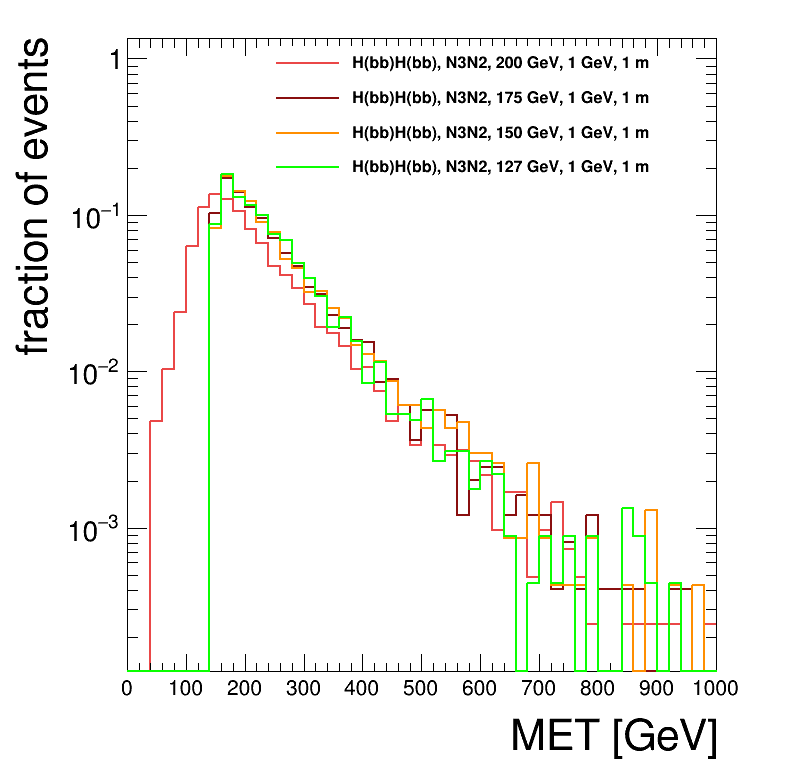

In [9]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)


    j_gamma_all = met_num_1[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_num_1.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
[ 79.277115 124.74917  194.55235  162.68413  168.43448  253.7527
 282.0586   165.60492  211.39606  166.84543 ]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
[357.03992 175.39574 192.82822 263.81476 191.32048 225.11838 193.22992
 267.20688 172.076   164.05458]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
[271.55627 212.86575 189.91356 162.74739 168.1627  150.08948 162.9984
 227.48718 288.10394 205.04498]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>
[245.0651  159.27563 172.45016 183.79437 179.2841  268.9957  278.48087
 182.51865 174.00159 151.95746]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


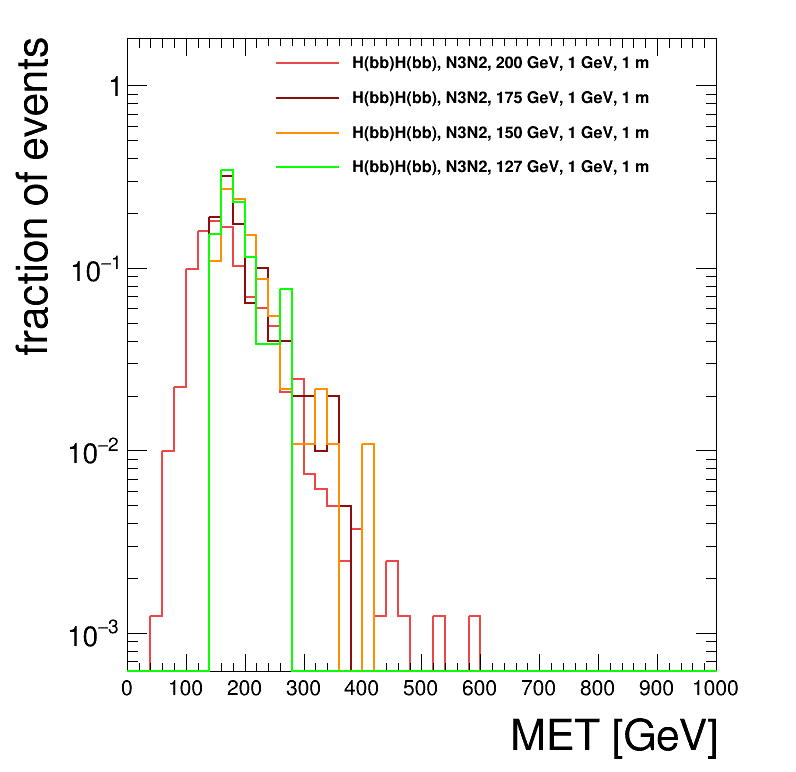

In [10]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)


    j_gamma_all = met_num_2[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_num_2.png')

## turn on

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbd1845860>
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb943e80>
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcb2f87b8>
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbbcae06fd0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200121/eff_met_all_H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200121/eff_met_all_H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200121/eff_met_all_H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200121/eff_met_all_H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m.png has been created


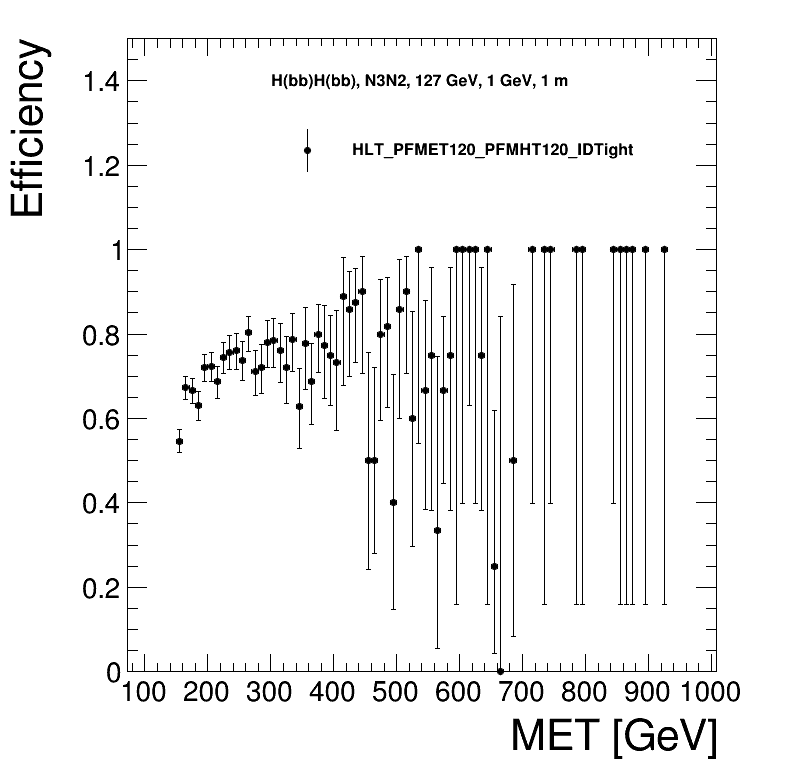

In [12]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
 

for k,v in tree.items(): 
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    
    pNum = num_all[k]
    pDen = den_all[k]
    
    #plot
    pEff = rt.TEfficiency(pNum, pDen)
    pEff.SetTitle("efficiency;MET [GeV];Efficiency")

    pEff.SetMarkerSize(0.8)
    pEff.SetMarkerStyle(20)
    pEff.Draw("apez")

    rt.gPad.Update()        
    #pEff.GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
    pEff.GetPaintedGraph().SetMarkerStyle(8)
    pEff.GetPaintedGraph().SetMarkerSize(20)        
    pEff.GetPaintedGraph().SetMinimum(0)
    pEff.GetPaintedGraph().SetMaximum(1.5)
    pEff.GetPaintedGraph().GetXaxis().SetLabelSize(0.04)
    pEff.GetPaintedGraph().GetYaxis().SetLabelSize(0.04)
    i += 1


    pEff.Draw()
    
    leg.SetHeader(k)
    leg.AddEntry(pEff, 'HLT_PFMET120_PFMHT120_IDTight', 'ep')
    
    leg.Draw()

#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'eff_met_all_'+k+'.png')